# Imports

In [12]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import copy

# Classes

In [21]:
class Particle:
    def __str__(self):
        return "Position: %s, Velocity: %s, Accleration: %s" % (self.position, self.velocity, self.acceleration)
    
    def __repr__(self):
        return "Position: %s, Velocity: %s, Accleration: %s" % (self.position, self.velocity, self.acceleration)
    
    def __init__(self, position=np.array([None]), velocity=np.array([None]), acceleration=np.array([None]), max_start=1):
        if position.all() == None:
            self.position = np.array([np.random.sample()*2-1,np.random.sample()*2-1]) * max_start # Position X, Y
        else:
            self.position = position
        
        if velocity.all() == None:
            self.velocity = np.array([np.random.sample()*2-1,np.random.sample()*2-1]) * max_start # Velocity X, Y
        else:
            self.velocity = velocity
            
        if acceleration.all() == None:
            self.acceleration = np.array([np.random.sample()*2-1,np.random.sample()*2-1]) * max_start # Acceleration X, Y
        else:
            self.acceleration = acceleration
        
        
    def apply_physics(self,dt):
        nextParticle = copy.deepcopy(self) # Copy to retain initial values
        nextParticle.position += self.velocity * dt
        nextParticle.velocity += self.acceleration * dt
        return nextParticle
    
    def predict(self,model):
        pred = model.predict(np.array(self.as_list()).reshape(-1,6))[0]
        return Particle(np.array([pred[0],pred[1]]),np.array([pred[2],pred[3]]),self.acceleration)
    
    def as_list(self):
        return [self.position[0],self.position[1],self.velocity[0], self.velocity[1], self.acceleration[0], self.acceleration[1]]
    
    def physics_as_list(self,dt):
        n = self.apply_physics(dt)
        return [n.position[0], n.position[1], n.velocity[0], n.velocity[1]]
    
    def get_actual_trajectory(self, dt, time):
        temp = copy.deepcopy(self)
        position = []
        velocity = []
        for _ in np.arange(0,time,dt):
            position.append(temp.position)
            velocity.append(temp.velocity)
            temp = temp.apply_physics(dt)
        return position, velocity
    
    def get_predicted_trajectory(self, model, dt, time):
        temp = copy.deepcopy(self)
        position = []
        velocity = []
        for _ in np.arange(0,time,dt):
            position.append(temp.position)
            velocity.append(temp.velocity)
            temp = temp.predict(model)
        return position, velocity

In [14]:
class DNN:
    def __init__(self, input_size, output_size, dropout=0.4, model=None):
        if model == None:
            self.model = self.generate_model(input_size, output_size, dropout)
        else:
            self.model = model
    
    def generate_model(self,input_size,output_size,dropout):
        optimizer = Adam()
        input_layer = Input(shape=(input_size,), name="Input") 
        dense_layer = Dense(128, activation='relu')(input_layer)
        dense_layer = Dropout(dropout)(dense_layer)
        dense_layer = Dense(256, activation='relu')(dense_layer)
        dense_layer = Dropout(dropout)(dense_layer)
        dense_layer = Dense(512, activation='relu')(dense_layer)
        dense_layer = Dropout(dropout)(dense_layer)
        dense_layer = Dense(256, activation='relu')(dense_layer)
        dense_layer = Dropout(dropout)(dense_layer)
        dense_layer = Dense(128, activation='relu')(dense_layer)
        dense_layer = Dropout(dropout)(dense_layer)
        output_layer = Dense(output_size, activation='tanh', name="Output")(dense_layer)
        model = Model(input_layer, output_layer)
        model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=['accuracy'])
        return model
    
    def train(self, data, labels, epochs = 150, batch_size = 32, save = True):
        self.model.fit(data, labels, epochs = epochs, batch_size = batch_size, verbose = 1)
        if save: 
            self.model.save("Model.h5")
        
    def predict(self, particle):
        return self.model.predict(particle)

In [15]:
def get_samples(dt, sample_size):
    object_list = []
    step = []
    for _ in range(sample_size):
        obj = Particle()
        object_list.append(obj.as_list())
        step.append(obj.physics_as_list(dt))
    return np.array(object_list), np.array(step)

In [16]:
X, y = get_samples(dt=0.1, sample_size=100000)

In [17]:
dnn = DNN(input_size=6, output_size=4)
dnn.train(X, y, epochs=100, batch_size=100)

Epoch 1/100
100000/100000 [==============================] - 13s 126us/step - loss: 0.0491 - acc: 0.7896
Epoch 2/100
100000/100000 [==============================] - 12s 119us/step - loss: 0.0277 - acc: 0.8318
Epoch 3/100
100000/100000 [==============================] - 12s 119us/step - loss: 0.0237 - acc: 0.8433
Epoch 4/100
100000/100000 [==============================] - 12s 119us/step - loss: 0.0218 - acc: 0.8505
Epoch 5/100
100000/100000 [==============================] - 12s 121us/step - loss: 0.0203 - acc: 0.8555
Epoch 6/100
100000/100000 [==============================] - 12s 123us/step - loss: 0.0192 - acc: 0.8600
Epoch 7/100
100000/100000 [==============================] - 12s 124us/step - loss: 0.0184 - acc: 0.8616
Epoch 8/100
100000/100000 [==============================] - 12s 119us/step - loss: 0.0177 - acc: 0.8648
Epoch 9/100
100000/100000 [==============================] - 12s 120us/step - loss: 0.0172 - acc: 0.8681
Epoch 10/100
100000/100000 [===========================

Epoch 78/100
100000/100000 [==============================] - 12s 118us/step - loss: 0.0115 - acc: 0.8907
Epoch 79/100
100000/100000 [==============================] - 12s 117us/step - loss: 0.0114 - acc: 0.8905
Epoch 80/100
100000/100000 [==============================] - 12s 117us/step - loss: 0.0113 - acc: 0.8904
Epoch 81/100
100000/100000 [==============================] - 12s 117us/step - loss: 0.0115 - acc: 0.8928
Epoch 82/100
100000/100000 [==============================] - 12s 118us/step - loss: 0.0114 - acc: 0.8925
Epoch 83/100
100000/100000 [==============================] - 12s 119us/step - loss: 0.0114 - acc: 0.8932
Epoch 84/100
100000/100000 [==============================] - 12s 118us/step - loss: 0.0115 - acc: 0.8897
Epoch 85/100
100000/100000 [==============================] - 12s 117us/step - loss: 0.0114 - acc: 0.8918
Epoch 86/100
100000/100000 [==============================] - 12s 117us/step - loss: 0.0115 - acc: 0.89231s -
Epoch 87/100
100000/100000 [==============

# Testing Data

In [22]:
Position = []
Velocity = []

for _ in range(10):
    obj = Particle(max_start=0.2)
    p1, v1 = obj.get_actual_trajectory(dt=0.1, time=3)
    p2, v2 = obj.get_predicted_trajectory(model=dnn.model, dt=0.1, time=3)
    Position.append([p1,p2])
    Velocity.append([v1,v2])

# Plotting

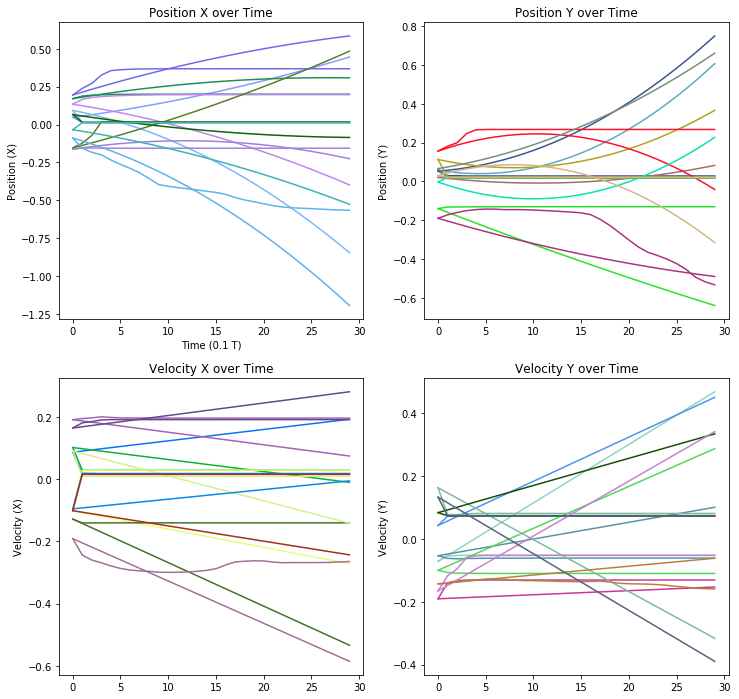

In [23]:
plt.figure(num=None, figsize=(12, 12))

for particle in Position:
    plt.subplot(2, 2, 1)
    
    plt.xlabel("Time (0.1 T)")
    plt.ylabel("Position (X)")
    plt.title("Position X over Time")
    
    c = [np.random.random_sample(),np.random.random_sample(),np.random.random_sample()]
    
    for trajectory in particle:
        plt.plot([t[0] for t in trajectory],color=c)
    
    plt.subplot(2, 2, 2)

    plt.ylabel("Position (Y)")
    plt.title("Position Y over Time")
    
    c = [np.random.random_sample(),np.random.random_sample(),np.random.random_sample()]

    for trajectory in particle:
        plt.plot([t[1] for t in trajectory],color=c)

for particle in Velocity:
    plt.subplot(2, 2, 3)

    plt.ylabel("Velocity (X)")
    plt.title("Velocity X over Time")
    
    c = [np.random.random_sample(),np.random.random_sample(),np.random.random_sample()]
    
    for trajectory in particle:
        plt.plot([t[0] for t in trajectory],color=c)

    plt.subplot(2, 2, 4)
    
    plt.ylabel("Velocity (Y)")
    plt.title("Velocity Y over Time")
    
    c = [np.random.random_sample(),np.random.random_sample(),np.random.random_sample()]

    for trajectory in particle:
        plt.plot([t[1] for t in trajectory],color=c)
    
        
plt.show()

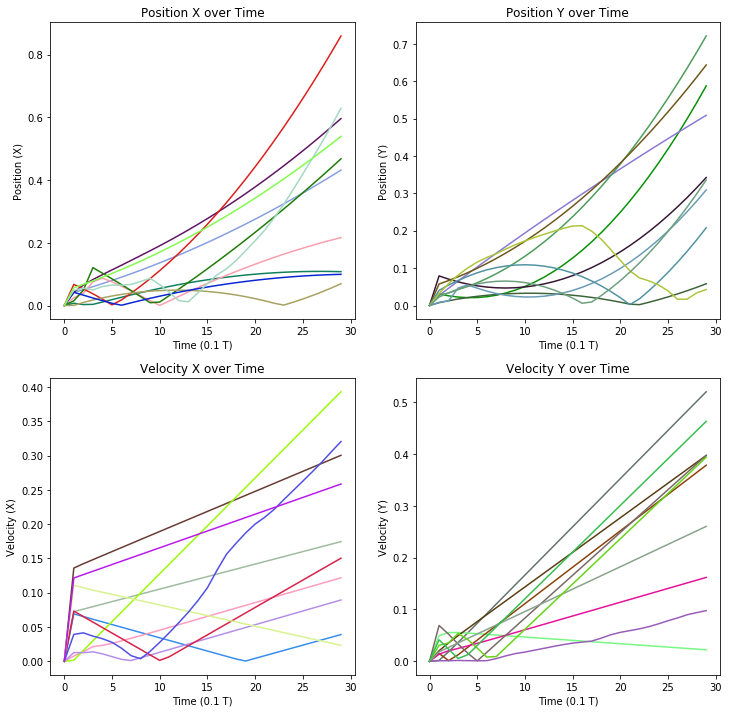

In [24]:
plt.figure(num=None, figsize=(12, 12))

for particle in Position:
    trajectory = abs(np.array(particle[0]) - np.array(particle[1]))
    
    plt.subplot(2, 2, 1)
    
    plt.xlabel("Time (0.1 T)")
    plt.ylabel("Position (X)")
    plt.title("Position X over Time")
    
    c = [np.random.random_sample(),np.random.random_sample(),np.random.random_sample()]

    plt.plot([t[0] for t in trajectory],color=c)
    
    plt.subplot(2, 2, 2)
    plt.xlabel("Time (0.1 T)")
    plt.ylabel("Position (Y)")
    plt.title("Position Y over Time")
    
    c = [np.random.random_sample(),np.random.random_sample(),np.random.random_sample()]

    plt.plot([t[1] for t in trajectory],color=c)

for particle in Velocity:
    trajectory = abs(np.array(particle[0]) - np.array(particle[1]))
    
    plt.subplot(2, 2, 3)
    plt.xlabel("Time (0.1 T)")
    plt.ylabel("Velocity (X)")
    plt.title("Velocity X over Time")
    
    c = [np.random.random_sample(),np.random.random_sample(),np.random.random_sample()]

    plt.plot([t[0] for t in trajectory],color=c)

    plt.subplot(2, 2, 4)
    plt.xlabel("Time (0.1 T)")
    plt.ylabel("Velocity (Y)")
    plt.title("Velocity Y over Time")
    
    c = [np.random.random_sample(),np.random.random_sample(),np.random.random_sample()]

    plt.plot([t[1] for t in trajectory],color=c)
    
        
plt.show()

# Network Architecture

In [12]:
dnn.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________